# Quickstart

Let's assume that you want to use **apollinaire** to fit p-mode parameters for
a given star. First we need to import the package :

In [1]:
import apollinaire as apn
from astropy.io import fits
from os import path
import numpy as np
import matplotlib.pyplot as plt
import apollinaire.timeseries as timeseries
import importlib.resources
%matplotlib inline
matplotlib.rcParams['font.size'] = 18

In [2]:
apn.__version__

'1.2'

The name of the stars we are going to work with is KIC 6603624, also known as Saxo. 
The package include a version of the light curve calibrated following the KEPSEISMIC 
method (see García et al. 2014). 

Text(0, 0.5, 'Luminosity variation (ppm)')

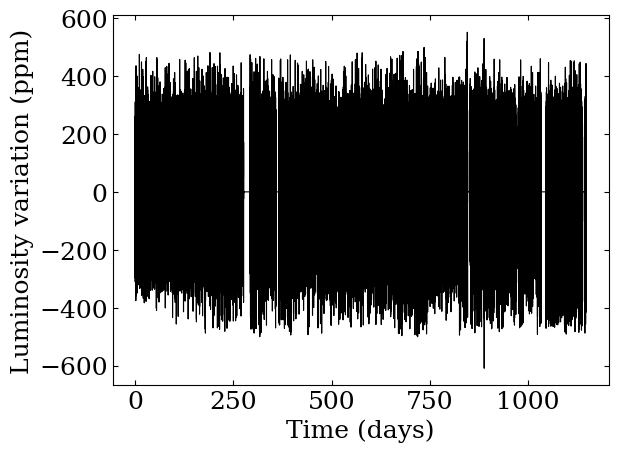

In [3]:
t, v = apn.timeseries.load_light_curve (star='006603624')

fig, ax = plt.subplots ()
ax.plot (t-t[0], v, color='black')

ax.set_xlabel ('Time (days)')
ax.set_ylabel ('Luminosity variation (ppm)')

Let's compute the psd of this lightcurve with the dedicated function:

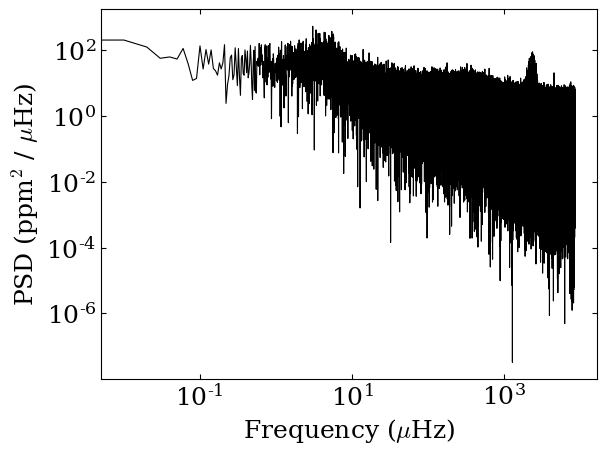

In [4]:
dt = np.median (t[1:] - t[:-1]) * 86400
freq, psd = apn.psd.series_to_psd (v, dt=dt, correct_dc=True)
freq = freq*1e6
psd = psd*1e-6

fig, ax = plt.subplots ()
ax.plot (freq, psd, color='black')
ax.set_xlabel (r'Frequency ($\mu$Hz)')
ax.set_ylabel (r'PSD (ppm$^2$ / $\mu$Hz)')
ax.set_yscale ('log')
ax.set_xscale ('log')

Here are the p-modes we want to fit :

Text(0, 0.5, 'PSD (ppm$^2$ / $\\mu$Hz)')

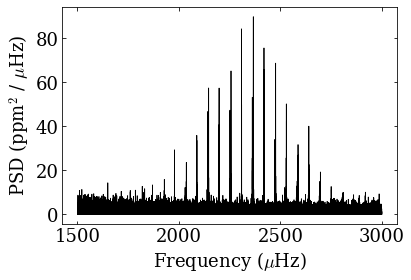

In [5]:
fig, ax = plt.subplots ()
cond = (freq>1500.)&(freq<3000.)
ax.plot (freq[cond], psd[cond], color='black')
ax.set_xlabel (r'Frequency ($\mu$Hz)')
ax.set_ylabel (r'PSD (ppm$^2$ / $\mu$Hz)')

We can also take a look at the echelle diagram of the modes. For this purpose, we have to know $\Delta\nu$, the large separation. An estimation of $\Delta\nu$ can be obtained through the scaling law, knowing mass and radius of the star (taken for example from the DR25 *Kepler* catalog, Mathur et al. 2017 or the Gaia-*Kepler* catalog, Berger et al. 2020). Here we want to have a nice plot, so let's cheat a little by taking a value which is closest to the $\Delta\nu$ we would obtain after performing the fit !

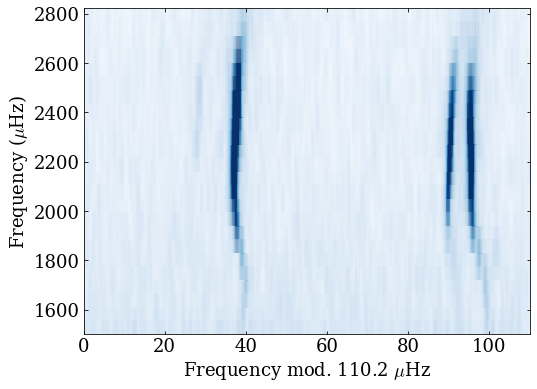

In [6]:
dnu = 110.2
ed = apn.psd.echelle_diagram (freq[cond], psd[cond], dnu, smooth=100, 
                              cmap='Blues', shading='gouraud', vmax=5, 
                              figsize=(8,6))

The main peakbagging tool provided by *apollinaire* is the `stellar_framework` function. It will successively fit the background of the star, the global pattern of the p-modes, and finally the individual parameters of the modes. Radius, mass and effective temperature are needed as input. 

In [7]:
r, m, teff = 1.162, 1.027, 5671
apn.peakbagging.stellar_framework (freq, psd, r, m, teff, n_harvey=2, low_cut=50., filename_back='background.png',
                                   filemcmc_back='mcmc_background.h5', nsteps_mcmc_back=2000, n_order=3, 
                                   n_order_peakbagging=5, filename_pattern='pattern.png', fit_l3=True,
                                   filemcmc_pattern='mcmc_pattern.h5', nsteps_mcmc_pattern=2000, parallelise=True, 
                                   quickfit=True, num=500, discard_pkb=400, progress=False, bins=50, extended=True,
                                   a2z_file='modes_param.a2z', format_cornerplot='png', nsteps_mcmc_peakbagging=2000, 
                                   filename_peakbagging='summary_peakbagging.png', dpi=300, plot_datapoints=False)

mcmc_background.h5 already exists, existing chains set to 'read', no sampling has been performed, proceeding to next step.
mcmc_pattern.h5 already exists, existing chains set to 'read', no sampling has been performed, proceeding to next step.
Orders to fit: 18, 19, 20, 21, 22
Fitting on order 18
Window width: 96.2 muHz
Chain will be saved at: ./mcmc_sampler_order_18.h5
./mcmc_sampler_order_18.h5 already exists, existing chains set to 'read', no sampling has been performed, proceeding to next step.
Ensemble sampling achieved
Fitting on order 19
Window width: 96.2 muHz
Chain will be saved at: ./mcmc_sampler_order_19.h5
./mcmc_sampler_order_19.h5 already exists, existing chains set to 'read', no sampling has been performed, proceeding to next step.
Ensemble sampling achieved
Fitting on order 20
Window width: 96.1 muHz
Chain will be saved at: ./mcmc_sampler_order_20.h5
./mcmc_sampler_order_20.h5 already exists, existing chains set to 'read', no sampling has been performed, proceeding to ne

In the first step of analysis, the stellar background activity is fitted in order to be removed from the spectrum:

![background plot](background.png)

From now on, the real spectrum is divided by the fitted background spectrum.
The second step of the automated analysis is to adjust a global pattern on the
p-mode bump using a limited set of parameters: $\epsilon$, $\alpha$, $\Delta_\nu$, 
$\nu_\mathrm{max}$, $H_\mathrm{max}$, $W_\mathrm{env}$, $w$, $\delta\nu_{02}$, 
$\beta\nu_{02}$, $\delta\nu_{01}$, $\beta\nu_{01}$, $\delta\nu_{13}$, $\beta\nu_{03}$
(see Breton et al., submitted, for more details). 

Note that it is possible to fit only the pairs 02 by setting the argument
`fit_l1` and `fit_l3` to `False`. The parameters $\delta\nu_{01}$, $\beta\nu_{01}$, $\delta\nu_{13}$ 
and $\beta\nu_{03}$ will not be fitted in this case. In the current version of the code, it is 
not possible to fit $\ell=3$ modes without fitting $\ell=1$.

This is what the fitted global pattern looks like:

![pattern plot](pattern.png)

The individual mode parameters are extracted thanks to a final series of MCMC
explorations, performed on each radial order. `n_order` around |numax| were
used to fit the global pattern, but it is possible to fit more modes: the
argument `n_order_peakbagging` allows you to choose the number of orders you
want to fit at this step. This parameter is set to 5 for this example. Here is
for example what we get when fitting order **n=21**:

![cornerplot example](mcmc_sampler_order_21_cornerplot.png )

The global profile fitted (including the background) can finally be visualised thanks to
the summary plot:

![summary peakbagging](summary_peakbagging.png )

## Dealing with existing hdf5 files

A MCMC fit is not meant to be perfect on the first run. It is sometimes useful
to make a first exploration run and to resample then chains that are not
converged yet. The **apollinaire** library allows doing so through the
`existing_chains` arguments of the MCMC sampling functions. Existing files
can simply be read (`read` option) to yield the results of previous runs but
can also be reseted if you are not satisfied at all by the result (`reset`
option). If you feel you have to carry on sampling, use the `sample` option
and the MCMC exploration will restart from where it stopped. The default
behaviour is `read`.

## A word about uncertainties

When you want to fit interest parameters, it is always good to be aware of
the way uncertainties are computed.  In **apollinaire**, output values and their
uncertainties are computed the following way: once the posterior probability
distribution has been sampled, the output value is selected as the median of
the distribution. The 16th and 84th centiles are also selected. If the
distribution has been sampled over the natural logarithm of the given
parameter, median and both centiles are transformed back. Differences between,
first, the median and the 16th centile and, secondly, the 84th centile and the
median are then computed.  The returned uncertainty corresponds then to largest
of those two values.

You may also want to keep an eye both on uncertainties from the 16th and 84th
centiles (especially for parameter for which it is the natural logarithm that
has been fitted). It is possible by generating an extended summary file through
the `extended` option of `stellar_framework` and `peakbagging`. If you
already have sampled the chains, just rerun your code with the `read` options
for existing chains and `extended=True` and the library will yield you your
extended output file without sampling anything else.